In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# Statistical Inference 

 #### To answer the question  "To what extent does YouTube ensure diversity of content in the trending videos?" we performed Statistical Inference with the Null and Alternative Hypothesis as follows:

**Null Hypothesis**: Any diversity of content that we see is merely due to chance 

**Alternative Hypothesis**: The diversity that we see is consciously ensured by YouTube algorithm

For our study, the observed statistic is the absolute difference in the counts of metrics e.g views, likes and comments between the two comparison categories. The test statistic is the absolute distance from this observed difference. 

Before we can apply statistical inference, data has to be prepared by cleaning and merging from the individual csv files in our data set. We first begin by seeing the prevalence of all the categories in each region


In [2]:
countries = ['CA', 'DE', 'FR', 'GB', 'IN', 'US', 'MX', 'KR', 'RU', 'JP']
category_dicts = {}
dfs = {}
regionwise_cateogry_counts = {}
for country in countries:
    json_data = 'Dataset/' + country + '_category_id.json'
    json_file = open(json_data, 'r')
    read_all = json_file.read()
    read_all = read_all.replace('true', 'True')
    read_all = read_all.replace('false', 'False')
    read_all = eval(read_all)

    items = read_all['items']
    category_dict = {}
    for kv_pairs in items:
        video_id = int(kv_pairs['id'])
        video_category = kv_pairs['snippet']['title']
        category_dict.update({video_id:video_category})
    category_dicts.update({country:category_dict})
    df_name = 'Dataset/' + country +'videos.csv'
    df_temp = pd.read_csv(df_name, usecols=['category_id', 'trending_date', 'likes', 'dislikes', 'views', 'comment_count'])
    dfs.update({country:df_temp})
    df_analysis = df_temp[['category_id', 'trending_date']]
    df_groupyby_category = df_analysis.groupby('category_id').count()['trending_date']
    count_by_category = {}
    for ids in category_dict:
        try: 
            count_by_category.update({category_dict[ids]:int(df_groupyby_category[ids])})
        except KeyError:
            continue
    
    regionwise_cateogry_counts.update({country:count_by_category})
    
preference_df = pd.DataFrame.from_dict(regionwise_cateogry_counts)
preference_df.drop(axis = 0, labels=['Nonprofits & Activism', 'Trailers', 'Movies'], inplace = True)
preference_df.fillna(0, inplace = True)
preference_df = preference_df.astype(int)
preference_df

,CA,DE,FR,GB,IN,US,MX,KR,RU,JP
Film & Animation,2060,2376,2157,2577,1658,2345,1298,2200,3041,1220
Autos & Vehicles,353,873,673,144,72,384,252,120,1583,280
Music,3731,2372,3946,13754,3858,6472,3371,1825,1895,1290
Pets & Animals,369,251,237,534,3,920,83,735,604,1127
Sports,2787,2752,4342,1907,731,2174,4050,936,1968,2037
Travel & Events,392,141,119,96,8,402,117,96,262,143
Gaming,1344,1565,1459,1788,66,817,994,1392,1043,1030
People & Blogs,4105,5988,5719,2926,2624,3210,8159,7056,10350,3915
Comedy,3773,2534,4343,1828,3429,3457,1742,2056,3065,743
Entertainment,13451,15292,9819,9124,16712,9964,13487,8955,5943,6259


From the dataframe collected for all regions, we only keep 5 fields namely category, views, likes, dislikes, comment_count. We assume that the YouTube algorithm could be assigning different weights to each field, however, it seems fit to combine likes and dislikes fields at this point as one field to capture user interaction with videos in terms of likes/dislikes

The following function creates a dataframe with relevant for the country specified out of the large dataset

In [3]:
def create_dataframe(country):
    data  = dfs[country]
    region_data = pd.DataFrame(data)
    region_data['category'] = region_data['category_id'].map(category_dict)
    region_data = region_data[['category', 'views', 'likes', 'dislikes', 'comment_count']]
    region_data["likes_dislikes"] = region_data['likes'] + region_data['dislikes']
    return region_data
    

This function first removes outliers from the field of interest and then computes the test statistic


In [4]:
def get_observed_difference(category1, category2, dataframe, interaction_field):
    q_low = dataframe[interaction_field].quantile(0.01)
    q_hi  = dataframe[interaction_field].quantile(0.99)
    df_filtered = dataframe[(dataframe[interaction_field] < q_hi) & (dataframe[interaction_field] > q_low)]
    
    mean1 = df_filtered[df_filtered['category']== category1][interaction_field].mean()
    mean2 = df_filtered[df_filtered['category']== category2][interaction_field].mean()
    return abs(mean1 - mean2)

We created the following functions to simulate the test statistic and computed 1000 test statistic values under the Null hypothesis

In [12]:
def simulate_stat(category1, category2, dataframe, interaction_field):
    sample_tbl = dataframe.copy()
    interaction_array = sample_tbl[interaction_field].values
    np.random.shuffle(interaction_array)
    sample_tbl[interaction_field] = interaction_array
    return get_observed_difference(category1, category2, sample_tbl, interaction_field)

In [13]:
def fill_simulated_array(category1, category2, dataframe, interaction_field):
    simulated_array = np.array([])
    for i in np.arange(1000):
        x = simulate_stat(category1, category2,dataframe,interaction_field)
        simulated_array = np.append(simulated_array,x)
    return simulated_array

Functions to create and plot histograms for simulated test statistics of each of the user interaction fields

In [20]:
def create_histogram(category1, category2,simulated_stats_array, observed_stat, hist_color, line_color, interaction_field):
    figure(num=None, figsize=(25, 11), dpi=250, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots()
    result = plt.hist(simulated_stats_array, density=True, color=hist_color, edgecolor='k')
    plt.axvline(observed_stat, color=line_color, linestyle='dashed', linewidth=3)
    ax.set_title("Distribution of Simulated Test Statistic under Null Hypothesis for "+interaction_field, fontsize=9, fontweight='bold')
    ax.set_xlabel("Test Statistic")
    ax.set_ylabel("Percent per unit")
    ax.text(0.15, 0.85, 'Simulated test statistic for '+category1+' and '+category2, fontsize=9,  color='black',transform=ax.transAxes,style='italic',
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5})
    plt.savefig(category1+category2+interaction_field+'.png', dpi = 150)
    plt.show()

In [21]:
def perform_tests(category1, category2, dataframe):
    observed_difference_views = get_observed_difference(category1, category2, dataframe, "views")
    simulated_stats_array_views = fill_simulated_array(category1, category2, dataframe, "views")
    views_p_value = np.count_nonzero(simulated_stats_array_views>=observed_difference_views) / 100
    create_histogram(category1, category2,simulated_stats_array_views,observed_difference_views, 'purple', 'blue', "views")

    observed_difference_dislikes = get_observed_difference(category1, category2, dataframe, "likes_dislikes")
    simulated_stats_array_dislikes = fill_simulated_array(category1, category2, dataframe, "likes_dislikes")
    dislikes_p_value = np.count_nonzero(simulated_stats_array_dislikes>=observed_difference_dislikes) / 100
    create_histogram(category1, category2, simulated_stats_array_dislikes,observed_difference_dislikes, 'cyan', 'orange', "likes_dislikes")


    observed_difference_comments = get_observed_difference(category1, category2, dataframe, "comment_count")
    simulated_stats_array_comments = fill_simulated_array(category1, category2, dataframe, "comment_count")
    comments_p_value = np.count_nonzero(simulated_stats_array_comments>=observed_difference_comments) / 100
    create_histogram(category1, category2,simulated_stats_array_comments,observed_difference_comments, 'yellow', 'green', "comments")
    
    p_array = [views_p_value, dislikes_p_value, comments_p_value]
    return p_array

Just to get started, we first picked a region, United States and the top 2 most popular genre of videos there to see if we are able to gauge anything significant from the statistical inference functions designed 

<Figure size 6250x2750 with 0 Axes>

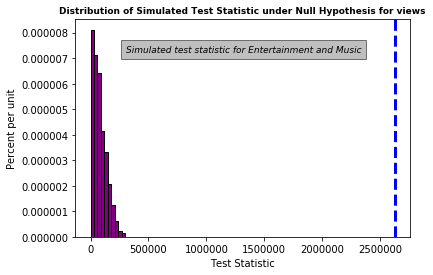

<Figure size 6250x2750 with 0 Axes>

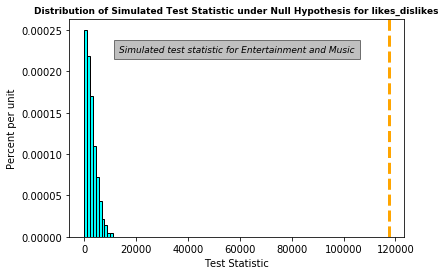

<Figure size 6250x2750 with 0 Axes>

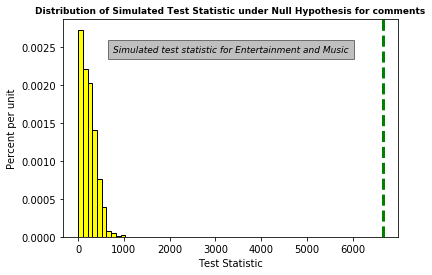

In [22]:
US_df = create_dataframe('US')
US_preferences = preference_df[['US']]
US_preferences_count = US_preferences.copy()


max1 = US_preferences_count.idxmax(axis = 0, skipna = True)
US_preferences_count.drop([max1[0]], inplace = True)
max2 = US_preferences_count.idxmax(axis = 0, skipna = True)
US_preferences_count.drop([max2[0]], inplace = True)

max_categories = [max1[0], max2[0]]

US_new_df = US_df[US_df.category.isin(max_categories)]

p_array = perform_tests(max1[0], max2[0], US_new_df)


Clearly, Alternative Hypothesis is observed for all the user interaction fields. However, we cannot make any educated guesses just yet. Now let's pick two categories at random from the same region and see if we are able to stumble upon something intelligible in that case.


<Figure size 6250x2750 with 0 Axes>

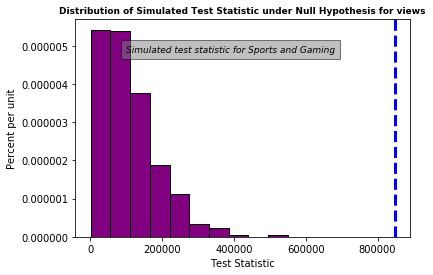

<Figure size 6250x2750 with 0 Axes>

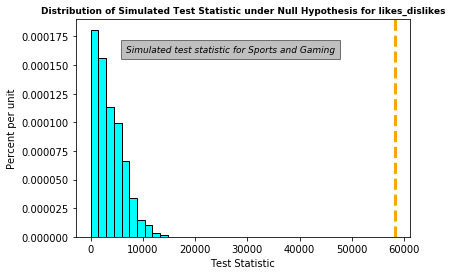

<Figure size 6250x2750 with 0 Axes>

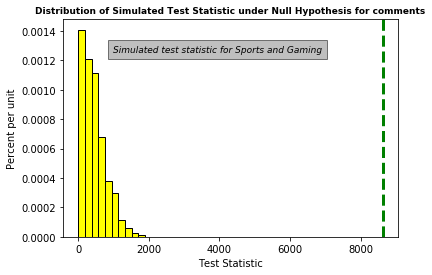

In [26]:
random_categories = US_preferences.sample(n=2)
category1 = random_categories[:1].index.to_numpy()
category1 = category1[0]
category2 = random_categories[1:2].index.to_numpy()
category2 = category2[0]

categories = [category1, category2]

US_new_df = US_df[US_df.category.isin(categories)]

p_array = perform_tests(category1, category2, US_new_df)


### What does the p value for views, likes/dislikes and comments tell us? 

In [24]:
views_p_value = p_array[0]
comments_p_value = p_array[1]
dislikes_p_value = p_array[2]

print("p value for views:",views_p_value)
print("p value for comments:",comments_p_value)
print("p value for likes and dislikes:",dislikes_p_value)

p value for views: 0.0
p value for comments: 0.0
p value for likes and dislikes: 0.02


The p values for each field, reiterate that the Null hypothesis has to be rejected. Thus far, all the iterations point to the claim under our Alternative Hypothesis that YouTube consciously tries to ensure diversity in the trending section of videos 

Even though we could not gather evidence for the Null hypothesis for USA, let's try once again for another region. This time we picked Great Britain as Music category stands in stark contrast in terms of popularity to other categories. So we'll compare Music category with any other category at random and investigate the Null hypothesis further


<Figure size 6250x2750 with 0 Axes>

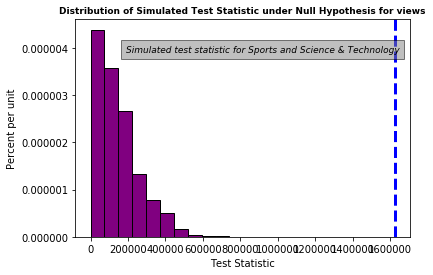

<Figure size 6250x2750 with 0 Axes>

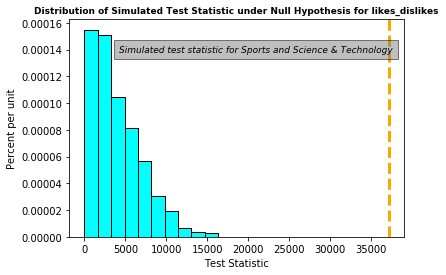

<Figure size 6250x2750 with 0 Axes>

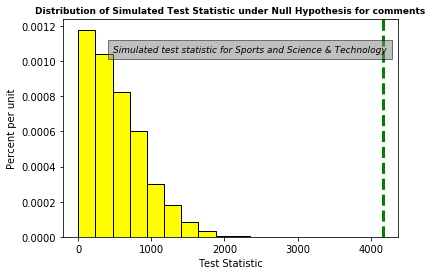

In [27]:
GB_df = create_dataframe('GB')
GB_preferences = preference_df[['GB']]
GB_preferences_count = GB_preferences.copy()

category1 = random_categories[:1].index.to_numpy()
category1 = category1[0]
GB_preferences_count.drop(category1, inplace = True)
random_categories = GB_preferences_count.sample(n=1)

category2 = random_categories[:1].index.to_numpy()
category2 = category2[0]

categories = [category1, category2]
#print(categories)
GB_new_df = GB_df[GB_df.category.isin(categories)]

p_array = perform_tests(category1, category2, GB_new_df)


Again, the Null hypothesis is rejected in favor of the Alternative Hypothesis. With consistent results from all our tests so far, it seems quite likely that YouTube accepts videos of some categories regardless of the user interaction they garner in order to maintain a trending section comprising of different categories instead of a select few for each country


